# 2. Evaluation of Subject Sensitivity using Receptive Operating Curve (ROC)

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from scipy import stats
from pingouin import rm_anova

In [5]:
# Load the data
data = pd.read_csv("data.csv")
subjects = pd.read_csv("subjectInfo.csv")

# Check for missing values
print("Missing values in data:")
print(data.isna().sum())

data = data.dropna()

# Filter only 'same' blockType
data_same = data[data['blockType'] == 'same']

data_same

Missing values in data:
trialKeys        0
levelFreq        0
levelFace        0
lCueName         0
rCueName         0
srespLoc       548
srespChoice    548
RT             548
Hand             0
blockType        0
subjectId        0
dtype: int64


,trialKeys,levelFreq,levelFace,lCueName,rCueName,srespLoc,srespChoice,RT,Hand,blockType,subjectId
0,AbHa,LF,1,Hasan,Abbas,right,Abbas,0.672450,Left,same,sub1
1,MahGol,LF,3,Goli,Mahnaz,right,Mahnaz,2.157862,Left,same,sub1
2,AbHa,LF,-3,Hasan,Abbas,right,Abbas,1.110335,Left,same,sub1
3,AbHa,LF,0,Hasan,Abbas,right,Abbas,0.676922,Left,same,sub1
4,MahGol,LF,0,Goli,Mahnaz,right,Mahnaz,0.970347,Left,same,sub1
...,...,...,...,...,...,...,...,...,...,...,...
50395,MahGol,IF,-2,Goli,Mahnaz,right,Mahnaz,0.420876,Right,same,sub38
50396,AbHa,IF,-2,Hasan,Abbas,right,Abbas,0.629925,Right,same,sub38
50397,MahGol,IF,-1,Goli,Mahnaz,right,Mahnaz,1.611287,Right,same,sub38
50398,AbHa,IF,-1,Hasan,Abbas,left,Hasan,0.917896,Right,same,sub38


In [28]:
def compute_roc(data):
    data = data[data['levelFace'] != 0]

    true_labels = data['levelFace'] > 0  # Positive levels mean 'Hasan'
    predictions = data['srespChoice'].isin(['Hasan', 'Goli'])

    return roc_auc_score(true_labels, predictions)

In [13]:
def compute_separability(data, cond_key=None):
    aucs_dict = defaultdict(list)

    for sid in data['subjectId'].unique():
        sub_data = data[data['subjectId'] == sid]
        aucs_dict[('subjectId', '') if cond_key else 'subjectId'].append(sid)

        for pair in sub_data['trialKeys'].unique():
            if cond_key is None:
                subset = sub_data[sub_data['trialKeys'] == pair]
                auc = compute_roc(subset)
                aucs_dict[pair].append(auc)
            else:
                for cond_value in data[cond_key].unique():
                    subset = sub_data[(sub_data['trialKeys'] == pair) & (sub_data[cond_key] == cond_value)]
                    auc = compute_roc(subset)
                    aucs_dict[(pair, cond_value)].append(auc)

    return pd.DataFrame(aucs_dict)

In [14]:
def stat_test(data, parametric_test, nonparametric_test, alternative=None, alpha=0.05):
    # Normality check
    p_normal = all(stats.shapiro(group)[1] >= alpha for group in data)
    
    # Choose test based on normality
    if p_normal >= alpha:
        test_name = parametric_test.__name__
        test = parametric_test
    else:
        test_name = nonparametric_test.__name__
        test = nonparametric_test
    
    if alternative:
        result = test(*data, alternative=alternative)
    else:
        result = test(*data)
        
    print(f"{test_name}: statistic = {result.statistic:.1f}, p-value = {result.pvalue:.4f}")

In [15]:
def plot_violin(data, xlabel, name):
    sns.violinplot(data=data)
    plt.xlabel(xlabel)
    plt.ylabel('Beta')
    plt.title(name)
    plt.savefig(f"ROC violin_plot {xlabel}.pdf", bbox_inches="tight", dpi=300, metadata={'Date': None})

### 1.2.1. Whether Separability to detecting identity from different spatial frequency bands differs.

AbHa friedmanchisquare: statistic = 14.1, p-value = 0.0009
MahGol friedmanchisquare: statistic = 56.3, p-value = 0.0000


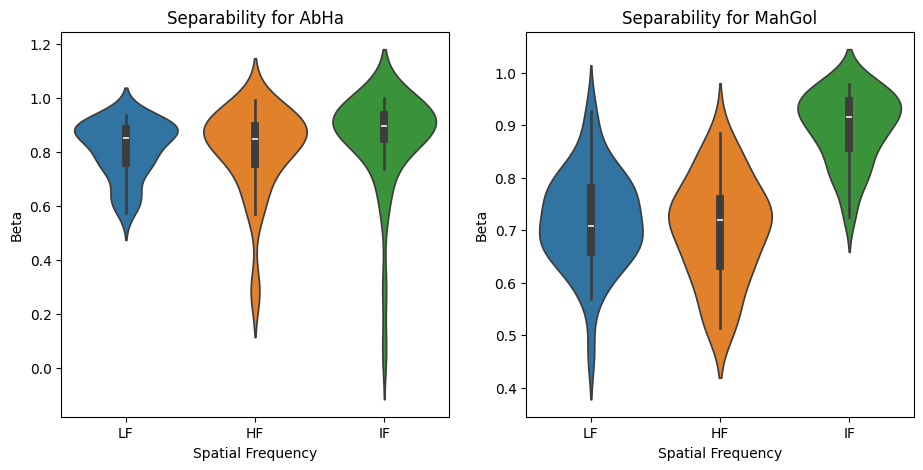

In [21]:
pivot_freq = compute_separability(data_same, 'levelFreq')

plt.figure(figsize=(11, 5))
for i, pair in enumerate(['AbHa', 'MahGol']):
    print(pair, end=' ')
    stat_test(pivot_freq[pair].values.T, rm_anova, stats.friedmanchisquare)
    plt.subplot(1, 2, i + 1)
    plot_violin(pivot_freq[pair], "Spatial Frequency", f"Separability for {pair}")

AbHa IF vs LF wilcoxon: statistic = 159.5, p-value = 0.0017
AbHa IF vs HF wilcoxon: statistic = 235.5, p-value = 0.0512
AbHa LF vs HF wilcoxon: statistic = 338.0, p-value = 0.6462
MahGol IF vs LF wilcoxon: statistic = 1.5, p-value = 0.0000
MahGol IF vs HF wilcoxon: statistic = 0.0, p-value = 0.0000
MahGol LF vs HF ttest_rel: statistic = 1.0, p-value = 0.3332


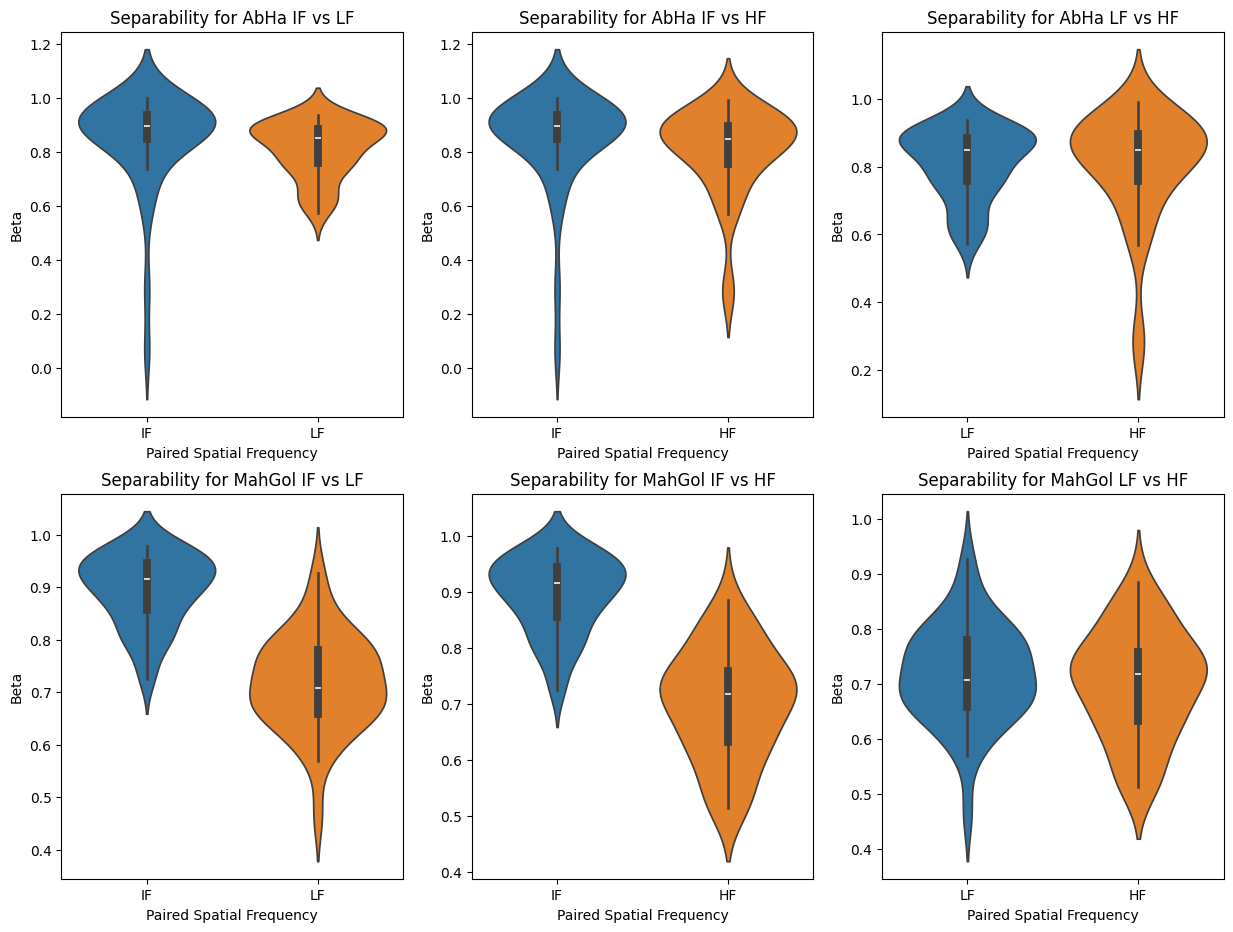

In [22]:
plt.figure(figsize=(15, 11))
for i, pair in enumerate(['AbHa', 'MahGol']):
    print(f'{pair} IF vs LF', end=' ')
    stat_test(pivot_freq[pair][['IF', 'LF']].values.T, stats.ttest_rel, stats.wilcoxon)
    print(f'{pair} IF vs HF', end=' ')
    stat_test(pivot_freq[pair][['IF', 'HF']].values.T, stats.ttest_rel, stats.wilcoxon)
    print(f'{pair} LF vs HF', end=' ')
    stat_test(pivot_freq[pair][['LF', 'HF']].values.T, stats.ttest_rel, stats.wilcoxon)

    plt.subplot(2, 3, 3 * i + 1)
    plot_violin(pivot_freq[pair][['IF', 'LF']], "Paired Spatial Frequency", f"Separability for {pair} IF vs LF")
    plt.subplot(2, 3, 3 * i + 2)
    plot_violin(pivot_freq[pair][['IF', 'HF']], "Paired Spatial Frequency", f"Separability for {pair} IF vs HF")
    plt.subplot(2, 3, 3 * i + 3)
    plot_violin(pivot_freq[pair][['LF', 'HF']], "Paired Spatial Frequency", f"Separability for {pair} LF vs HF")

### 1.2.2 Whether people are more adept at identifying images of their conspecific or hetero-specific gender.

AbHa mannwhitneyu: statistic = 134.0, p-value = 0.1964
MahGol ttest_ind: statistic = 1.6, p-value = 0.1111


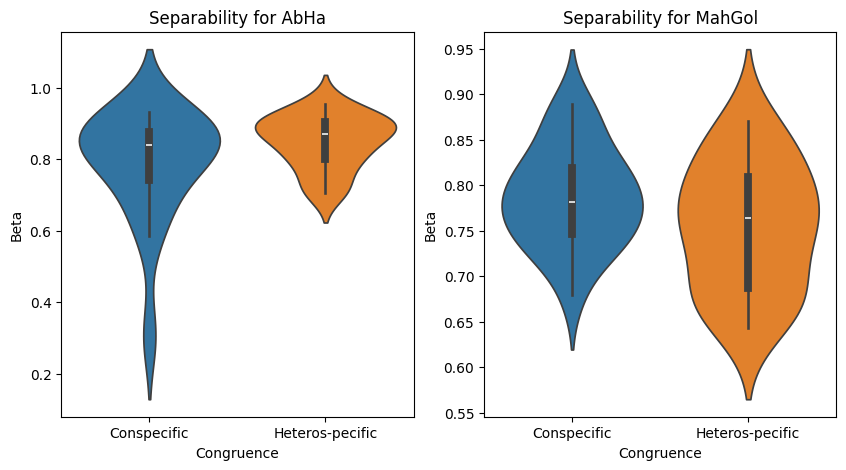

In [23]:
pivot_key = compute_separability(data_same)

plt.figure(figsize=(10, 5))
for i, pair in enumerate(['AbHa', 'MahGol']):
    pair_sex = 'M' if pair == 'AbHa' else 'F'
    conspecifics_beta = pivot_key[pair][subjects['sex'] == pair_sex].rename('Conspecific')
    hetro_specific_betas = pivot_key[pair][subjects['sex'] != pair_sex].rename('Heteros-pecific')
    pivot_congruence = [conspecifics_beta, hetro_specific_betas]

    print(pair, end=' ')
    stat_test(pivot_congruence, stats.ttest_ind, stats.mannwhitneyu)

    plt.subplot(1, 2, i + 1)
    plot_violin(pivot_congruence, "Congruence", f"Separability for {pair}")

### 1.2.3. Whether subjects can better detect identities in a specific spectral band if they use their left hand.

Hand Separability for IF
	AbHa wilcoxon: statistic = 363.0, p-value = 0.3186


/home/reza/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


	MahGol wilcoxon: statistic = 463.5, p-value = 0.0921
Hand Separability for LF
	AbHa wilcoxon: statistic = 283.5, p-value = 0.8978
	MahGol ttest_rel: statistic = -0.3, p-value = 0.6310
Hand Separability for HF
	AbHa wilcoxon: statistic = 397.5, p-value = 0.2438


/home/reza/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


	MahGol ttest_rel: statistic = -0.3, p-value = 0.6165


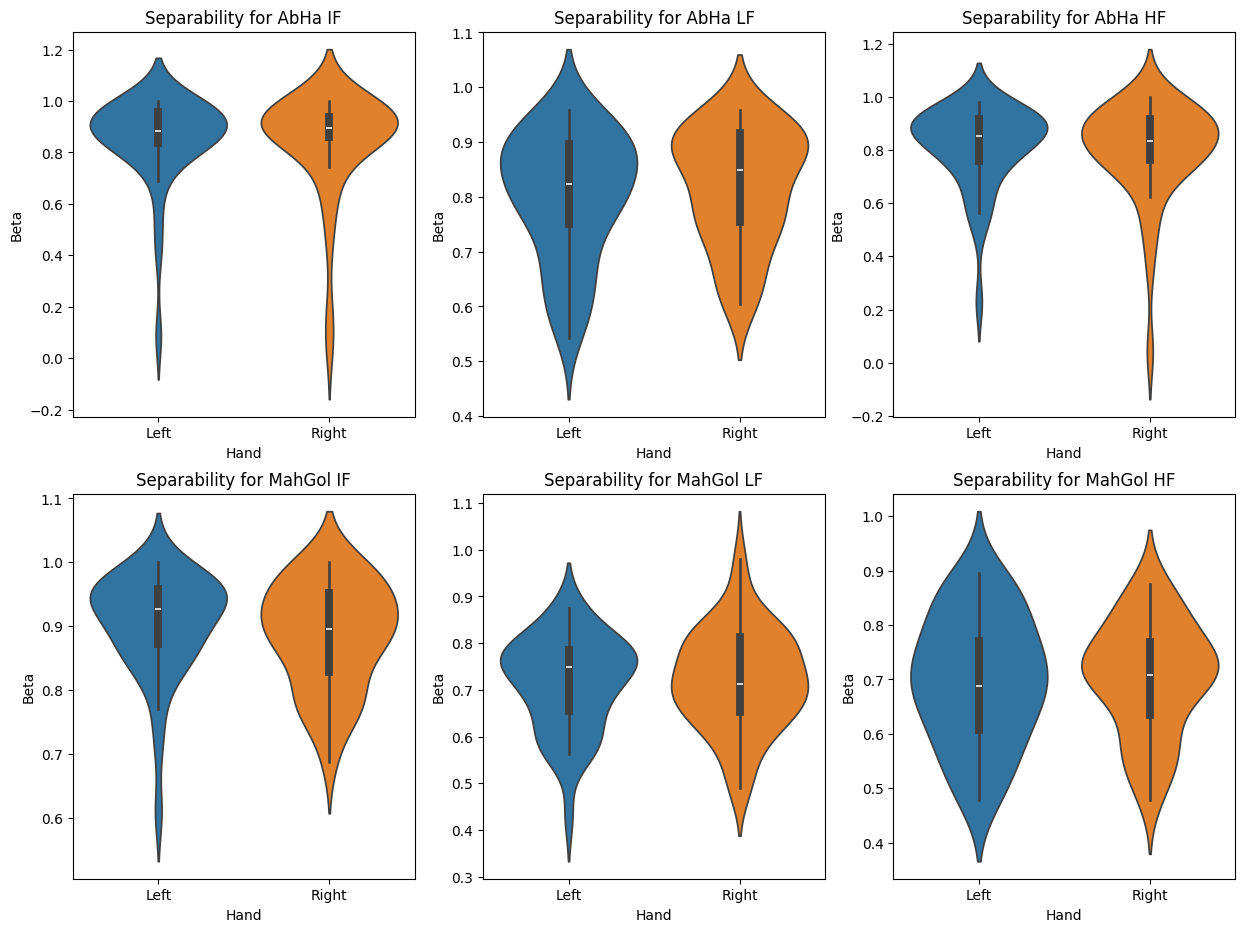

In [25]:
plt.figure(figsize=(15, 11))
for i, freq in enumerate(['IF', 'LF', 'HF']):
    print(f"Hand Separability for {freq}")
    pivot_hand = compute_separability(data_same[data_same['levelFreq'] == freq], 'Hand')

    for j, pair in enumerate(['AbHa', 'MahGol']):
        print(f'\t{pair}', end=' ')
        stat_test(pivot_hand[pair].values.T, stats.ttest_rel, stats.wilcoxon, alternative='greater')
        plt.subplot(2, 3, j * 3 + i + 1)
        plot_violin(pivot_hand[pair], "Hand", f"Separability for {pair} {freq}")

### 1.2.4. Whether subjects can better detect identities in a specific spectral band if they use their dominant hand.

Dominance Separability for IF
	AbHa wilcoxon: statistic = 309.0, p-value = 0.6470


/home/reza/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


	MahGol wilcoxon: statistic = 304.5, p-value = 0.8324
Dominance Separability for LF
	AbHa wilcoxon: statistic = 427.0, p-value = 0.2105
	MahGol wilcoxon: statistic = 374.5, p-value = 0.4829
Dominance Separability for HF
	AbHa wilcoxon: statistic = 325.0, p-value = 0.6554


/home/reza/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


	MahGol ttest_rel: statistic = -0.0, p-value = 0.5112


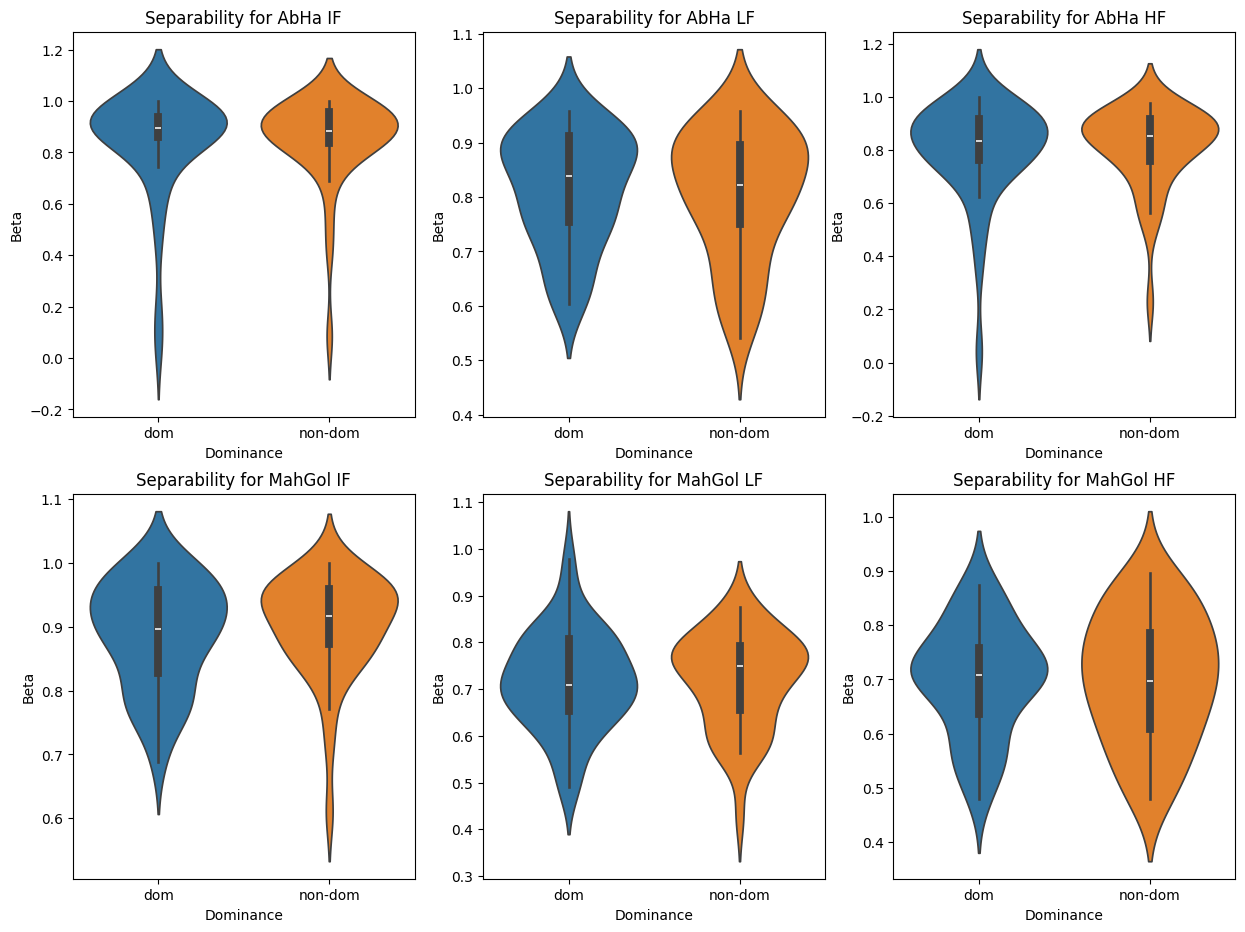

In [26]:
plt.figure(figsize=(15, 11))
for i, freq in enumerate(['IF', 'LF', 'HF']):
    print(f"Dominance Separability for {freq}")
    pivot_hand = compute_separability(data_same[data_same['levelFreq'] == freq], 'Hand')
    
    for j, pair in enumerate(['AbHa', 'MahGol']):
        pivot_dom = pd.DataFrame([{
                'dom': row['Right'] if row['dom'] == 'R' else row['Left'], 
                'non-dom': row['Left'] if row['dom'] == 'R' else row['Right']
            } for i, row in pivot_hand[pair].assign(dom=subjects['dom']).iterrows()])

        print(f'\t{pair}', end=' ')
        stat_test(pivot_dom[['dom', 'non-dom']].values.T, stats.ttest_rel, stats.wilcoxon, alternative='greater')
        plt.subplot(2, 3, j * 3 + i + 1)
        plot_violin(pivot_dom[['dom', 'non-dom']], "Dominance", f"Separability for {pair} {freq}")

### 1.2.5. Whether women are significantly better than men in the task of identity detection.

AbHa mannwhitneyu: statistic = 133.0, p-value = 0.1330
MahGol ttest_ind: statistic = -2.0, p-value = 0.0254


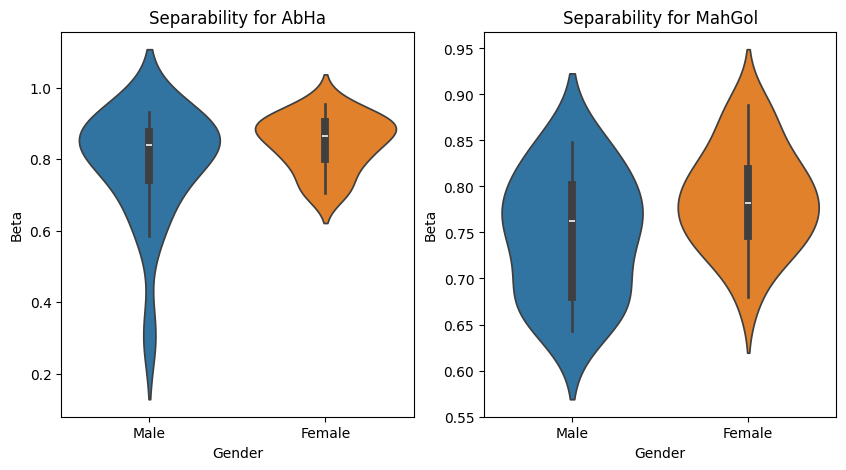

In [27]:
pivot_key = compute_separability(data_same)

plt.figure(figsize=(10, 5))
for i, pair in enumerate(['AbHa', 'MahGol']):
    male_beta = pivot_key[pair][subjects['sex'] == 'M'].rename('Male')
    female_beta = pivot_key[pair][subjects['sex'] == 'F'].rename('Female')
    pivot_gender = [male_beta, female_beta]

    print(f"{pair}", end=' ')
    stat_test(pivot_gender, stats.ttest_ind, stats.mannwhitneyu, alternative='less')
    plt.subplot(1, 2, i + 1)
    plot_violin(pivot_gender, 'Gender', f"Separability for {pair}")